In [40]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics as st
from IPython import display
from mpl_toolkits.mplot3d import Axes3D
import pathlib
import os
import shutil


In [41]:
#画像の枚数

initial_count = 0
for path in pathlib.Path("./imagefile/tryout").iterdir():
    if path.is_file():
        initial_count += 1

print(initial_count)

491


In [42]:
img=cv2.imread('./imagefile/tryout/img_000.jpg')

#img_resize = cv2.resize(img, dsize=[1920,1080], fx=None, fy=None)

#cv2.imwrite(img_path,img)

# HSVに変換
RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(RGB, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(hsv,cv2.CV_64F,1,0,ksize=5)

#plt.imshow(sobelx)
cv2.imwrite("./after/test.jpg",sobelx)

True

In [43]:
im_out = cv2.imread("./after/test.jpg")

# 画像をグレースケールで読み出しオブジェクトimg_grayに代入
img_gray = cv2.cvtColor(im_out,cv2.COLOR_BGR2GRAY)
# img_grayを平均化領域9x9で平均化処理しimg_blurに代入
img_blur = cv2.blur(img_gray,(9,9)) 

#閾値
threshold=120

# オブジェクトimg_blurを閾値thresholdで反転二値化しimg_binaryに代入
ret, img_binary= cv2.threshold(img_blur, threshold, 255, cv2.THRESH_BINARY_INV)
cv2.imwrite("./after/image0.jpg",img_binary) 
# img_binaryを輪郭抽出
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
#plt.imshow(img_binary)

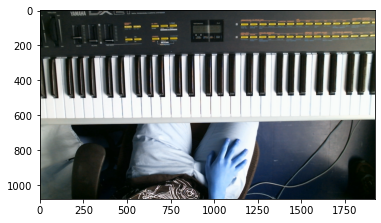

In [44]:
# 小さい輪郭は誤検出として削除する
contours = list(filter(lambda y: cv2.contourArea(y) > 50, contours))

ylen=[]

ID=0
for i in contours:
    y=[]
    rect = cv2.minAreaRect(i)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    #img = cv2.drawContours(im_out,[box],0,(0,255,0),2)
    #cv2.imwrite("./after/gaisetu"+str(ID)+".jpg",img)  
    plt.imshow(img)

    # 外接矩形の座標、回転角の表示
    #print(str(ID),'外接矩形の座標')
    #print(box,"\n")
    #print('回転角:')
    #print(rect[2])
   

    #各輪郭の左端、右端を取得
    for r in box:
        y+=[r[1]]
    #print(y)
    amin = np.amin(y)
    amax = np.amax(y)

    if amin > 0:
        if amax < 1080:
            ylen+=[[amin,amax]]
        else:ylen+=[[amin,1080]]
    else:
        if amax < 1080:
            ylen+=[[0,amax]]
        else:ylen+=[[0,1080]]
    
    ID+=1

In [45]:
hst=[0]*1080
i=0
while i<len(ylen):
    j=ylen[i][0]
    while j<ylen[i][1]:
        hst[j]+=1
        j+=1
    i+=1

In [46]:
#疑似的に積分し、最も輪郭が多い範囲を取得
i=0
hst+=[-1]
menseki=[]
ykenban=[]
while i<1080:
    sekibun=0
    while hst[i] < 20 and hst[i] != -1:
        i+=1
    ystart=i
    while hst[i] >= 20 and hst[i] != -1:
        sekibun+=hst[i]
        i+=1
    yend=i
    ykenban+=[[ystart,yend]]
    menseki+=[sekibun]
print(ykenban)
print(menseki)


ind=np.argmax(menseki)

[[64, 111], [123, 178], [243, 612], [1080, 1080]]
[1349, 1705, 15554, 0]


In [47]:
print(menseki)
print(np.argmax(menseki))

[1349, 1705, 15554, 0]
2


(1080, 1920)
(0, 293) (1920, 612)


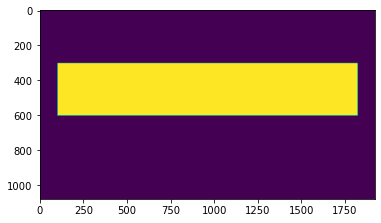

In [48]:
# マスク用単一色画像を作成



#若干の調整
yy = math.floor(1.5*(ykenban[ind][1]-ykenban[ind][0])) 
#height = yy*5
height = ykenban[ind][1]-ykenban[ind][0]


imgMask = np.full((1, 1, 1), 1, dtype=np.uint8)
imgMask_resize = cv2.resize(imgMask, dsize=[1920,1080], fx=None, fy=None)

imgMask_resize2 = cv2.resize(imgMask, dsize=[1920,1080], fx=None, fy=None)

print(imgMask_resize.shape)

# マスク範囲を四角形で描画
boxFromX = 0 #マスク範囲開始位置 X座標
boxFromY = ykenban[ind][0] + 50 #マスク範囲開始位置 Y座標
boxToX = 1920 #マスク範囲終了位置 X座標
boxToY = boxFromY + height -50 #マスク範囲終了位置 Y座標

#cv2.rectangle(imgMask_resize, (boxFromX, boxFromY), (boxToX, boxToY),(255), cv2.FILLED)

cv2.rectangle(imgMask_resize , (boxFromX+100, boxFromY+10), (boxToX-100, boxToY-10),(255), cv2.FILLED)
cv2.rectangle(imgMask_resize2, (boxFromX+100, boxFromY+10), (boxToX-100, boxFromY+int((yy-10)/2)),(255), cv2.FILLED)

# マスク結果画像を保存
cv2.imwrite("./mask/testMaskImg.jpg", imgMask_resize)    #黒鍵の長さ
cv2.imwrite("./mask/testMaskImg2.jpg", imgMask_resize2)  #白鍵の長さ
plt.imshow(imgMask_resize)
#plt.imshow(imgMask_resize2)
print((boxFromX,boxFromY),(boxToX,boxToY))

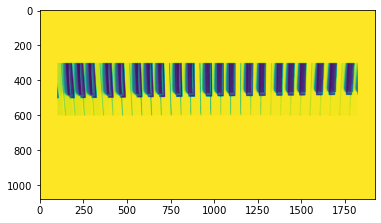

In [49]:
im_1 = cv2.imread('./imagefile/tryout/img_000.jpg', cv2.IMREAD_COLOR)
im_1 = cv2.cvtColor(im_1,cv2.COLOR_BGR2GRAY)
imgMask_resize_not = cv2.bitwise_not(imgMask_resize)
im_out = cv2.bitwise_or(im_1, imgMask_resize_not)
cv2.imwrite('./after/out.jpg', im_out)
plt.imshow(im_out)

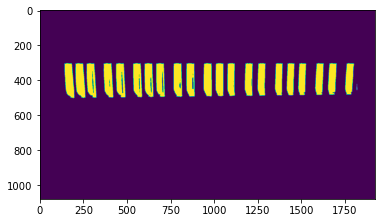

In [50]:
# 画像をグレースケールで読み出しオブジェクトimg_grayに代入
#img_gray = cv2.cvtColor(im_out,cv2.COLOR_BGR2GRAY)
# img_grayを平均化領域9x9で平均化処理しimg_blurに代入
img_blur = cv2.blur(im_out,(9,9)) 

#閾値
threshold=100

# オブジェクトimg_blurを閾値thresholdで反転二値化しimg_binaryに代入
ret, img_binary= cv2.threshold(img_blur, threshold, 255, cv2.THRESH_BINARY_INV)
cv2.imwrite("./after/image0.jpg",img_binary) 
# img_binaryを輪郭抽出
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
plt.imshow(img_binary)

0 外接矩形の座標
[[1745  481]
 [1757  302]
 [1799  305]
 [1787  483]] 

1 外接矩形の座標
[[1648  482]
 [1656  303]
 [1699  304]
 [1691  484]] 

2 外接矩形の座標
[[1575  483]
 [1582  303]
 [1625  305]
 [1617  485]] 

3 外接矩形の座標
[[1478  484]
 [1484  303]
 [1524  304]
 [1518  485]] 

4 外接矩形の座標
[[1412  486]
 [1417  303]
 [1457  304]
 [1452  487]] 

5 外接矩形の座標
[[1345  486]
 [1349  303]
 [1390  304]
 [1385  487]] 

6 外接矩形の座標
[[1246  488]
 [1248  303]
 [1291  304]
 [1288  489]] 

7 外接矩形の座標
[[1173  489]
 [1175  303]
 [1219  304]
 [1216  490]] 

8 外接矩形の座標
[[1073  304]
 [1114  303]
 [1116  490]
 [1074  491]] 

9 外接矩形の座標
[[1006  304]
 [1050  304]
 [1050  492]
 [1006  492]] 

10 外接矩形の座標
[[938 492]
 [938 303]
 [984 303]
 [984 492]] 

11 外接矩形の座標
[[836 304]
 [883 303]
 [886 493]
 [839 494]] 

12 外接矩形の座標
[[763 304]
 [810 303]
 [814 494]
 [766 495]] 

13 外接矩形の座標
[[662 304]
 [709 302]
 [715 494]
 [668 496]] 

14 外接矩形の座標
[[597 304]
 [644 303]
 [649 496]
 [602 497]] 

15 外接矩形の座標
[[530 304]
 [577 302]
 [584 496]
 [537 498]] 

16

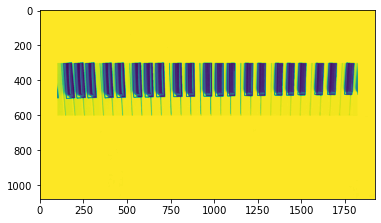

In [51]:
# 小さい輪郭は誤検出として削除する
contours = list(filter(lambda x: cv2.contourArea(x) > 1000, contours))


xleft=[]
xright=[]

ID=0
for i in contours:
    x=[]
    rect = cv2.minAreaRect(i)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    img = cv2.drawContours(im_out,[box],0,(0,255,0),2)
    cv2.imwrite("./after/gaisetu"+str(ID)+".jpg",img)  
    plt.imshow(img)

    # 外接矩形の座標、回転角の表示
    print(str(ID),'外接矩形の座標')
    print(box,"\n")
    #print('回転角:')
    #print(rect[2])
   

    #各輪郭の左端、右端を取得
    for  r in box:
        x+=[r[0]]
    xleft +=[np.amin(x)]
    xright+=[np.amax(x)]

    ID+=1

In [52]:
# クイックソートを行う関数
def quick_sort(x):
    # 基準値を抽出(半分の位置の値)
    n = len(x)
    pivot = x[int(n / 2)]

    # i番目の値と基準値を比較して左l、右r、真ん中mに追加
    l = []
    r = []
    m = []
    for i in range(n):
        sample = x[i]
        if sample < pivot:
            l.append(sample)
        elif sample > pivot:
            r.append(sample)
        else:
            m.append(sample)
    # lとrの場合でそれぞれ再帰処理による分割を行う
    if l:
        l = quick_sort(l)
    if r:
        r = quick_sort(r)
    return l + m + r

In [53]:
#端っこを追加
#xright=[0]+xright
#xleft =xleft+[1980]

In [54]:
xleft=quick_sort(xleft)
xright=quick_sort(xright)
print(xleft)
print(xright)

kokken=[[xleft[0],xright[0]]]
i=1
while i<len(xleft):
    kokken+=[[xleft[i],xright[i]]]
    i+=1

print(kokken)

[134, 197, 261, 361, 431, 530, 597, 662, 763, 836, 938, 1006, 1073, 1173, 1246, 1345, 1412, 1478, 1575, 1648, 1745]
[199, 260, 323, 420, 489, 584, 649, 715, 814, 886, 984, 1050, 1116, 1219, 1291, 1390, 1457, 1524, 1625, 1699, 1799]
[[134, 199], [197, 260], [261, 323], [361, 420], [431, 489], [530, 584], [597, 649], [662, 715], [763, 814], [836, 886], [938, 984], [1006, 1050], [1073, 1116], [1173, 1219], [1246, 1291], [1345, 1390], [1412, 1457], [1478, 1524], [1575, 1625], [1648, 1699], [1745, 1799]]


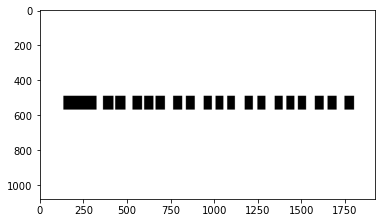

In [55]:
i=0
white = cv2.imread('./mask/white.jpg')
white_resize = cv2.resize(white, dsize=[1920,1080], fx=None, fy=None)
base=white_resize

while i<len(xleft):
    cv2.rectangle(base,
              (xleft[i], 568),
              (xright[i], 490),
              (0, 0, 0),
              thickness=-1,
              lineType=cv2.LINE_4,
              shift=0)

    i+=1
plt.imshow(base)

In [56]:
#白い部分の座標
hakkenkari=[[xright[0],xleft[1]]]
i=1
while i<len(xleft)-1:
    hakkenkari+=[[xright[i],xleft[i+1]]]
    i+=1
print(hakkenkari)

[[199, 197], [260, 261], [323, 361], [420, 431], [489, 530], [584, 597], [649, 662], [715, 763], [814, 836], [886, 938], [984, 1006], [1050, 1073], [1116, 1173], [1219, 1246], [1291, 1345], [1390, 1412], [1457, 1478], [1524, 1575], [1625, 1648], [1699, 1745]]


In [57]:
#両端切り抜き
#hakkenkari = hakkenkari[1:len(hakkenkari)-1]
#print(hakkenkari)

In [58]:
max = 0
min = 100
for i in hakkenkari:
    if i[0] != 0 and i[1] != 1920:

        if i[1]-i[0] > max:max = i[1]-i[0]
        if i[1]-i[0] < min:min = i[1]-i[0]

mean = (max+min)/2
print(mean)


27.5


In [59]:

hakkenlarge = []

#白鍵の正確な座標
i=0
j=0
hakken=[]
while i<len(hakkenkari):
    haklen=hakkenkari[i][1]-hakkenkari[i][0]
    if  haklen>mean:#別のところの値使いたい
        hakken+=[[hakkenkari[i][0],int((hakkenkari[i][0]*8+hakkenkari[i][1]*9)/17)]]+[[int((hakkenkari[i][0]*8+hakkenkari[i][1]*9)/17)+1,hakkenkari[i][1]]]
        hakkenlarge += [[hakkenkari[i][0],hakkenkari[i][1]]]

    else:
        hakken+=[[hakkenkari[i][0],hakkenkari[i][1]]]
        
    i+=1
print(hakken)

[[199, 197], [260, 261], [323, 343], [344, 361], [420, 431], [489, 510], [511, 530], [584, 597], [649, 662], [715, 740], [741, 763], [814, 836], [886, 913], [914, 938], [984, 1006], [1050, 1073], [1116, 1146], [1147, 1173], [1219, 1246], [1291, 1319], [1320, 1345], [1390, 1412], [1457, 1478], [1524, 1551], [1552, 1575], [1625, 1648], [1699, 1723], [1724, 1745]]


[[199, 197], [260, 261], [323, 343], [344, 361], [420, 431], [489, 510], [511, 530], [584, 597], [649, 662], [715, 740], [741, 763], [814, 836], [886, 913], [914, 938], [984, 1006], [1050, 1073], [1116, 1146], [1147, 1173], [1219, 1246], [1291, 1319], [1320, 1345], [1390, 1412], [1457, 1478], [1524, 1551], [1552, 1575], [1625, 1648], [1699, 1723], [1724, 1745]]


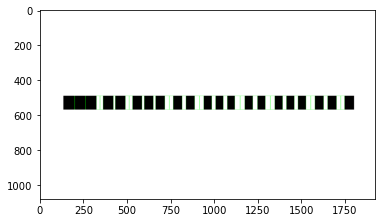

In [60]:
i=0

base=white_resize
while i<len(hakken):
    l=hakken[i][0]
    r=hakken[i][1]
    
    cv2.rectangle(base,
              (l,568),
              (r, 490),
              (0,255,0),
              thickness=1,
              lineType=cv2.LINE_4,
              shift=0)
    i+=1
cv2.imwrite("./after/hakken.jpg",base)
plt.imshow(base)
print(hakken)


In [61]:
#音の高さを検出
n=0 #右から何番目かを入力　左端は0 このプログラムだと0がシ
i=n

nanabit=[]
while i<7+n:
    print(hakken[i+1][0],hakken[i][1])
    if hakken[i+1][0]-hakken[i][1]>1:
        nanabit+=[0]
    else :
        nanabit+=[1]+[1]
        i+=1
    i+=1
if len(nanabit)>7:
    nanabit.pop(-1)
    nanabit[6]=0
print(nanabit)
i=6
tensin=0
k=1
while i>=0:
    tensin+=nanabit[i]*k
    k*=2
    i-=1

print(tensin)

260 197
323 261
344 343
489 431
511 510
[0, 0, 1, 1, 0, 1, 1]
27


In [62]:
if tensin==24:hstart=0
if tensin==51:hstart=1
if tensin==102:hstart=2
if tensin==12:hstart=3
if tensin==27:hstart=4
if tensin==54:hstart=5
if tensin==108:hstart=6
print(hstart)


4


In [63]:
#オクターブ
n=2

In [64]:
i=0
doremi=["C","D","E","F","G","A","B"]
hakkendoremi=[]
while i<len(hakken):
    hakkendoremi+=[str(doremi[(hstart+i)%7])+str(math.floor((hstart+i)/7)+n)]
    i+=1
print(hakkendoremi)

['G2', 'A2', 'B2', 'C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5', 'C6', 'D6', 'E6', 'F6']


True

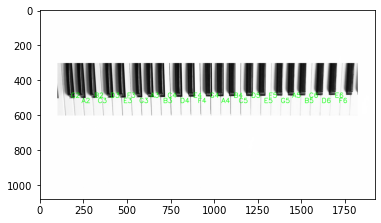

In [65]:
#base2 = cv2.imread("./after/white_resize.jpg")
#base2=im_out
base3=cv2.imread("./after/out.jpg")
plt.imshow(base3)
i=0
while i<len(hakken):
    t=i%2*30
    cv2.putText(base3,
            text=(str(doremi[(hstart+i)%7])+str(math.floor((hstart+i)/7)+n)),
            org=(math.floor((hakken[i][1]+hakken[i][0])/2)-22,500+t),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1.3,
            color=(0, 255, 0),
            thickness=2,
            lineType=cv2.LINE_4)
    i+=1

plt.imshow(base3)
cv2.imwrite("./after/doremi.jpg",base3)

In [66]:
if hstart==0 or hstart==6:bstart=0
if hstart==1 :bstart=1
if hstart==2 or hstart==3:bstart=2
if hstart==4 : bstart=3
if hstart==5 : bstart=4
bstart -=1
print(hstart,bstart)

4 2


In [67]:
sharp=["C#","D#","F#","G#","A#"]
if hstart==6:
    n+=1
i=0
kokkendoremi=[]
while i<len(kokken):
    kokkendoremi+=[str(sharp[(bstart+i)%5])+str(math.floor((bstart+i)/5)+n)]
    i+=1
print(kokkendoremi)

['F#2', 'G#2', 'A#2', 'C#3', 'D#3', 'F#3', 'G#3', 'A#3', 'C#4', 'D#4', 'F#4', 'G#4', 'A#4', 'C#5', 'D#5', 'F#5', 'G#5', 'A#5', 'C#6', 'D#6', 'F#6']


True

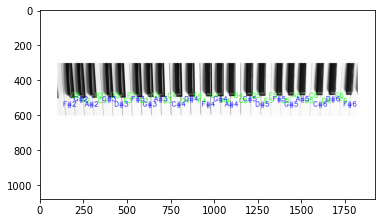

In [68]:
i=0
while i<len(kokken):
    t=i%2*30
    cv2.putText(base3,
            text=(str(sharp[(bstart+i)%5])+str(math.floor((bstart+i)/5)+n)),
            org=(math.floor((kokken[i][1]+kokken[i][0])/2)-35,550-t),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1.3,
            color=(0, 0, 255),
            thickness=2,
            lineType=cv2.LINE_4)
    i+=1

plt.imshow(base3)
cv2.imwrite("./after/doremi.jpg",base3)

In [69]:
#ミとシを特定しておく

k = 0
mi_and_si = []
do_and_fa = []

for i in hakkendoremi:
    if (i[0] == 'E') or (i[0] == 'B'):mi_and_si += [k]
    if (i[0] == 'C') or (i[0] == 'F'):do_and_fa += [k]

    k += 1

print(mi_and_si)
print(do_and_fa)

[2, 5, 9, 12, 16, 19, 23, 26]
[3, 6, 10, 13, 17, 20, 24, 27]


In [70]:
num = 0
hakkenfocus = []
hakkenfocus2 = []

mask = cv2.imread('./mask/kenbanmask.jpg')

shutil.rmtree('imagefile/kenban')
os.mkdir('imagefile/kenban')



while(1):
    
    img_number = num
    if img_number < 100:
        if img_number < 10:
            img_number = "0"+str(img_number)
        img_number = "0"+str(img_number)

    img1 = cv2.imread('./imagefile/tryout/img_'+str(img_number)+'.jpg')
    

    if img1 is None:
        break

    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

    i=0
    sumlist = []
    sumlist2 = []
    

    while i<len(hakken):

        if i in mi_and_si:      
            #img2 = img1[boxFromY+10:int((boxFromY+boxToY)/2),int((hakken[i][0]+hakken[i][1])/2):hakken[i][1]]
            img2 = img1[boxFromY:boxToY,int((hakken[i][0]+hakken[i][1])/2):hakken[i][1]]

    
        else:    
            if i in do_and_fa:  
                #img2 = img1[boxFromY+10:int((boxFromY+boxToY)/2),hakken[i][0]:int((hakken[i][0]+hakken[i][1]*3)/4)]
                img2 = img1[boxFromY:boxToY,hakken[i][0]:int((hakken[i][0]+hakken[i][1]*3)/4)]
            else:               
                #img2 = img1[boxFromY+10:int((boxFromY+boxToY)/2),hakken[i][0]:hakken[i][1]]
                img2 = img1[boxFromY:boxToY,hakken[i][0]:hakken[i][1]]
        
        
        
        sumlist += [np.average(img2.ravel(), axis = None, weights = None, returned = False)]
        
        img2_binary = cv2.threshold(img2,200,255,cv2.THRESH_BINARY)
        #print(img2_binary)

        if i ==14:

            sumlist2 += [img2.ravel()]
        
        
        i+=1

    
    


    hakkenfocus += [sumlist]
    hakkenfocus2 += sumlist2

    
    num += 1

c:\Users\user\anaconda3\envs\py39\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\user\anaconda3\envs\py39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [71]:
#転置
hakkenfocus_t = np.array(hakkenfocus).T.tolist()
hakkenfocus2_t = np.array(hakkenfocus2).T.tolist()

In [72]:
print(len(hakkenfocus2))
print(len(hakkenfocus2_t))
print(len(hakkendoremi))

491
7018
28


In [73]:
num=0
hakkenrange = []

finaldata = []

for i in hakkenfocus_t:
    img_number = num
    if img_number < 100:
        if img_number < 10:
            img_number = "0"+str(img_number)
        img_number = "0"+str(img_number)

    
    #ミとシ、ドとファ、その他で閾値を変える
    if num in mi_and_si:
        hakkenborder = hakkenfocus_t[num][0]*0.95
        x = [hakkenborder]*initial_count
    else:
        hakkenborder = hakkenfocus_t[num][0]*0.97
        x = [hakkenborder]*initial_count

    ccc = []
    if np.amax(i)-np.amin(i) > 10:
        for j in i:
            if j < hakkenborder:ccc += [1]
            else: ccc += [0]
    else:ccc = [0]*initial_count

    finaldata += [ccc] 
    
    
    
    plt.plot(i)
    plt.plot(x)
    
    plt.title(hakkendoremi[num])
    plt.savefig('./imagefile/plt/img_'+str(img_number)+'.jpg')
    plt.clf()



    """plt.plot(sample_t[num])
    plt.title(hakkendoremi[num])
    plt.savefig('./imagefile/plt/img_'+str(img_number)+'.jpg')
    plt.clf()"""

    hakkenrange += [np.amax(i)-np.amin(i)]

    num+=1
    



<Figure size 432x288 with 0 Axes>

In [74]:
print(hakkenlarge)

[[323, 361], [489, 530], [715, 763], [886, 938], [1116, 1173], [1291, 1345], [1524, 1575], [1699, 1745]]


In [75]:
#転置
finaldata_t = np.array(finaldata).T.tolist()

for i in range(0,len(finaldata_t)):
    print(finaldata_t[i])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [76]:
print(finaldata_t)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [77]:
print(hakkendoremi)

['G2', 'A2', 'B2', 'C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5', 'C6', 'D6', 'E6', 'F6']


In [78]:
keyinfo = []
for i in finaldata_t:
    data = []
    num = 0
    for j in i:
        if j == 1:data += [hakkendoremi[num]]
        num += 1
    keyinfo += [data]

print(keyinfo)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['A3', 'B3', 'C4', 'F4'], ['G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F4'], ['G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F4'], ['G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F4'], ['G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F4'], ['A3', 'B3', 'C4', 'D4', 'F4', 'G4'], ['A3', 'B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['A3', 'B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['A3', 'B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['A3', 'B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['A3', 'B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['B3', 'C4', 'D4', 'E4', 'F4', 'G4'], ['B3', 'C4', 'D4', 'E4', 'F4', 'G